# LSTM Batch Visualization script

In [1]:
%matplotlib inline
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from IPython.core.display import HTML
import matplotlib.ticker as ticker

sns.set_context('poster')
sns.set_style("whitegrid")
sns.light_palette("navy", as_cmap=True)

In [2]:
keywords = ['cellstates', 'probabilities', 'sample']
mapping = {1:'(',
           2:')',
           3:']',
           4:'['}

In [3]:
def parse_paren(some_string, some_palette):
    color_codes = {i:v for i,v in enumerate(some_palette.as_hex())}
    html_parse = '<div style="font-size:18pt; line-height: 24px">'
    depth = 0
    for c in some_string:
        if c == "(" or c == "[":
            #print " "*depth,"("
            html_parse += '<span style="color:{0};">{1}</span>'.format(color_codes[depth], c)
            depth+=1
            
        else:
            if depth > 0:
                depth-=1
            html_parse += '<span style="color:{0};">{1}</span>'.format(color_codes[depth], c)

            #print " "*depth,")"
    html_parse += "</div>"
    return HTML(html_parse)

In [4]:
def get_depth_for_samples(some_text):
    depth = 0
    depth_array = []
    for c in some_text:
        if c == "(" or c == "[":
            depth+=1
        elif depth > 0:
            depth-=1
        depth_array.append(depth)
    
    return depth_array

In [5]:
def get_correct_array(some_text):
    depth_array = []
    correct_array = []
    for c in some_text:
        if c == "(" or c == "[":
            depth_array.append(c)
            correct_array.append('g')
        else:
            try:
                curr_open = depth_array.pop()
                if (curr_open == "(" and c == ")") or (curr_open == "[" and c == "]"):
                    correct_array.append('g')
                else:
                    correct_array.append('r')
            except:
                correct_array.append('r')
    return correct_array
#str(get_correct_array(sample_text))

In [6]:
# plot to visualize excitement / importance of cellstate character by character
def plotNeuronExcitement(ax, cellstates, curr_sample, useAbs=True):
    # K is number of latent factors used by the cell state
    K = cellstates[0].shape[1]
    # N is the number of neurons
    N = len(cellstates)
    
    # different excitement metrics (each metric should return a value between 0 and 1 to allow comparison for different K)
    # input is the tanh(cellstate) vector for a node
    def absmetric(tanhC):
        return 0.5 * np.sum(np.abs(tanhC)) / tanhC.shape[0]
    def totmetric(tanhC):
        return (tanhC.shape[0] + np.sum(tanhC)) / (2 * tanhC.shape[0])

    for i in xrange(N):
        ax.plot(np.arange(cellstates[i].shape[0]), np.apply_along_axis(absmetric if useAbs == True else totmetric, 1, cellstates[i]), label='neuron %d' % (i+1))
    plt.legend(loc='best')

    # format ticks to input
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    plt.xticks([i+.5 for i in xrange(50-1)])
    # Customize minor tick labels
    ax.xaxis.set_minor_locator(ticker.FixedLocator([i for i in xrange(50-1)]))
    ax.xaxis.set_minor_formatter(ticker.FixedFormatter([mapping[i] for i in list(curr_sample.s)[:-1]]))
    


In [7]:
# heatmap plot for individual cellstate factors for each neuron
def plotNeuronHeatmap(ax, cellstates, curr_sample, useAbs=True):
    # K is number of latent factors used by the cell state
    K = cellstates[0].shape[1]
    # N is the number of neurons
    N = len(cellstates)
    
    cmaps = [plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]
    for i in xrange(N):
        x = np.arange(cellstates[i].shape[0] + 1)
        y = np.arange(cellstates[i].shape[1] + 1) + (N - i - 1) * K
        X, Y = np.meshgrid(x, y)

        ax.pcolor(X, Y, np.abs(cellstates[i].T) if useAbs == True else cellstates[i].T, cmap=cmaps[i % 4], alpha=0.8, edgecolors='w', lw=2)

    #  get equal axis ratio for better visually compelling results
    ax.set_aspect('equal')

    ax.set_xlim([0, cellstates[0].shape[0]])
    ax.set_ylim([0, N * cellstates[0].shape[1]])

    # format ticks to input
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    plt.xticks([i + .5 for i in xrange(cellstates[0].shape[0])])
    plt.yticks([((N - i - 1) + .5) * K for i in xrange(N)])
    
    # Customize minor tick labels
    ax.xaxis.set_minor_locator(ticker.FixedLocator([i+0.5 for i in xrange(cellstates[0].shape[0])]))
    ax.xaxis.set_minor_formatter(ticker.FixedFormatter([mapping[i] for i in list(curr_sample.s)[:-1]]))
    ax.yaxis.set_minor_locator(ticker.FixedLocator([((N - i - 1) + .5) * K for i in xrange(N)]))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter(['neuron %d ' % (i+1) for i in xrange(N)]))
    
# remove spines
def removeSpines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return ax


In [8]:
# create dir if it does not exists already
def create_dir(path):
    if not os.path.exists(path):
        try:
            os.makedirs(path)
        except OSError as error:
            if error.errno != errno.EEXIST:
                raise
    return path

In [9]:
# plt.figure(figsize=(20,4))
# ax1 = plt.subplot(312)
# depths_sample = get_depth_for_samples(sample_text)
# print len(depths_sample)
# correct_sample = get_correct_array(sample_text)
# x_vals = np.linspace(0,48,49)
# print len(x_vals)
# plt.scatter(x_vals, depths_sample, c=correct_sample)
# plt.xlim([0,49])
# plt.show()

def plotDepthPlot(fig, sample_text, curr_sample, curr_probs):
    x = np.array(curr_probs[['2','4']]).T#.reshape(4,50)

    ax1 = plt.subplot(312)
    depths_sample = get_depth_for_samples(sample_text)

    def beautifyRG(ll):
        return [sns.color_palette()[2] if l == 'r' else sns.color_palette()[1] for l in ll]

    correct_sample = beautifyRG(get_correct_array(sample_text))
    x_vals = np.linspace(0,48,49)
    plt.scatter(x_vals, depths_sample, c=correct_sample, s=100, edgecolor='none')
    ax1.set_ylabel('nesting depth')

    ax = plt.subplot(313, sharex=ax1)

    plt.imshow(x, interpolation='nearest', aspect=2, cmap=plt.cm.summer, alpha=.6)
    plt.xticks([i+.5 for i in xrange(50)])
    plt.yticks([.5,1.5]) #
    #plt.colorbar()

    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[1] = 'Testing'

    plt.grid(b=True, which='both', color='0.65',linestyle='')

    # a is an axes object, from figure.get_axes()

    # Hide major tick labels
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

    # Customize minor tick labels
    ax.xaxis.set_minor_locator(ticker.FixedLocator([i for i in xrange(50)]))
    ax.xaxis.set_minor_formatter(ticker.FixedFormatter([mapping[i] for i in list(curr_sample.s)[:-1]]))

    ax.yaxis.set_minor_locator(ticker.FixedLocator([0,1]))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter([')',']']))

    removeSpines(ax)
    figtitle = 'What does the LSTM predict given the depth and generated string?' 
    t = fig.text(.5, .65, figtitle,  
                   horizontalalignment='center',
                   fontsize=16) 

### Batch plotting code

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


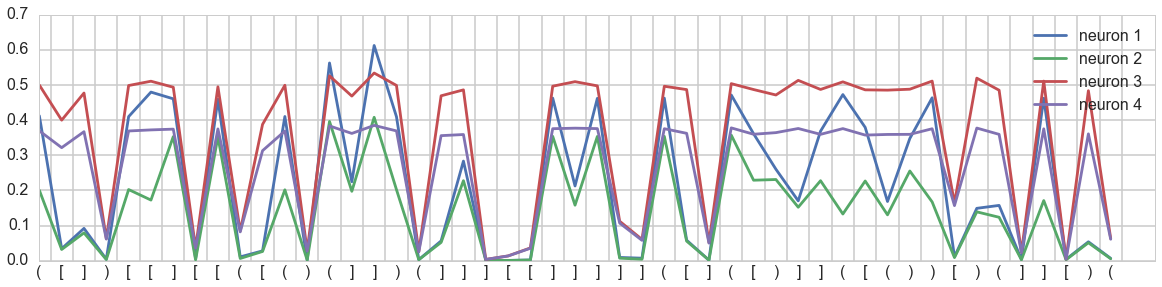

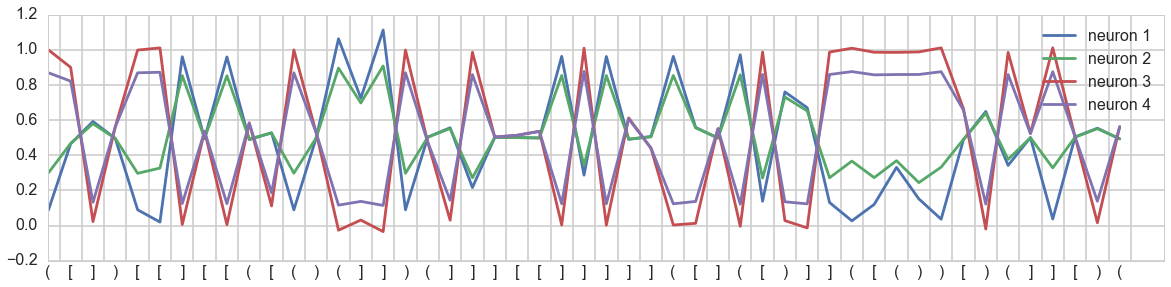

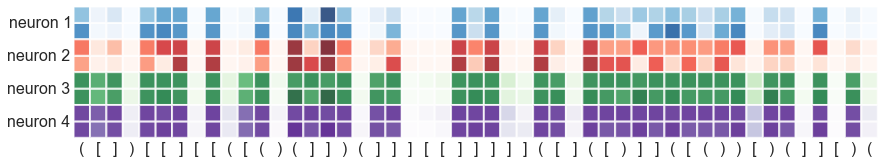

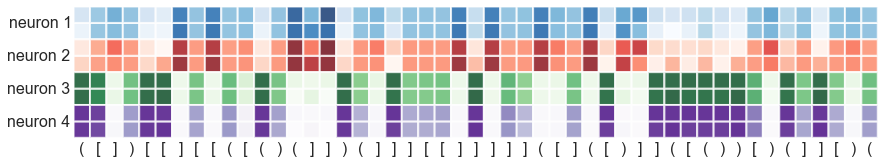

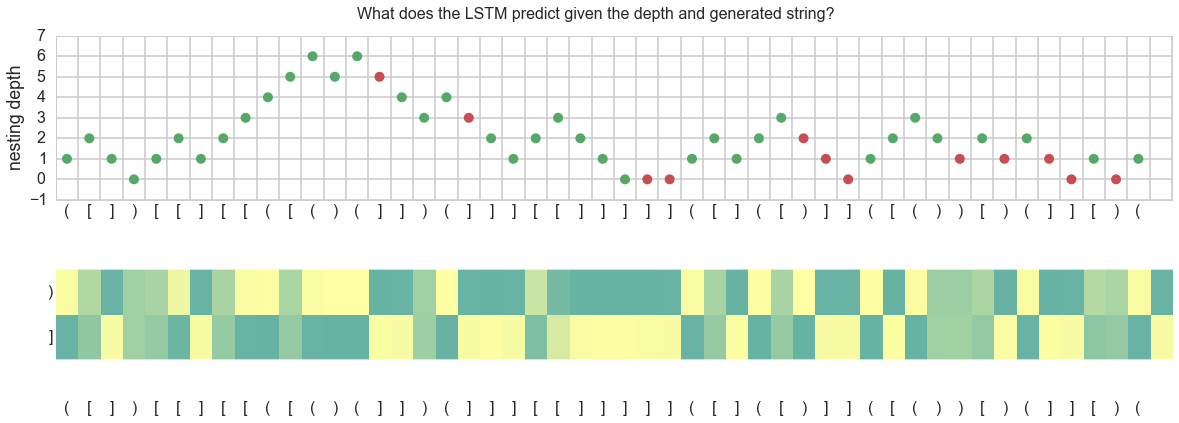

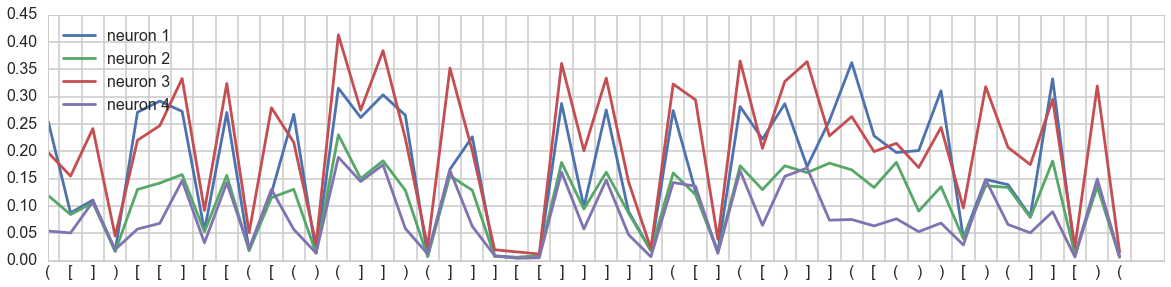

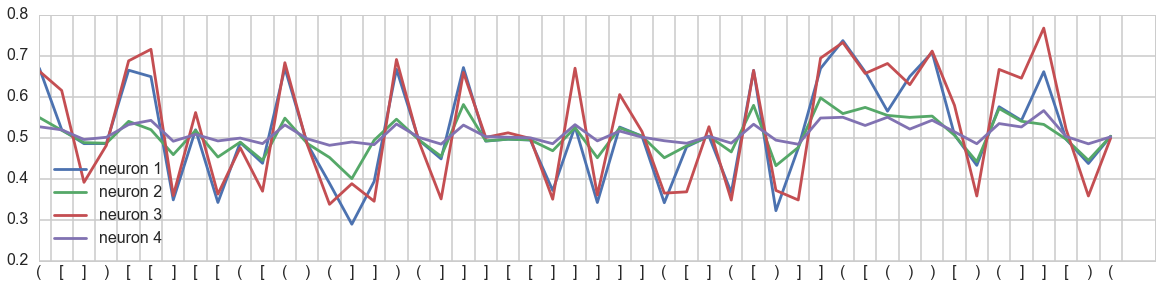

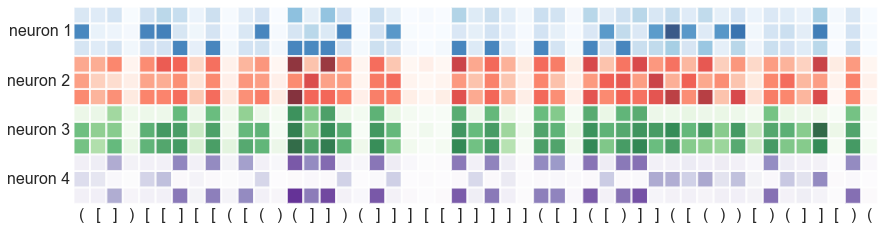

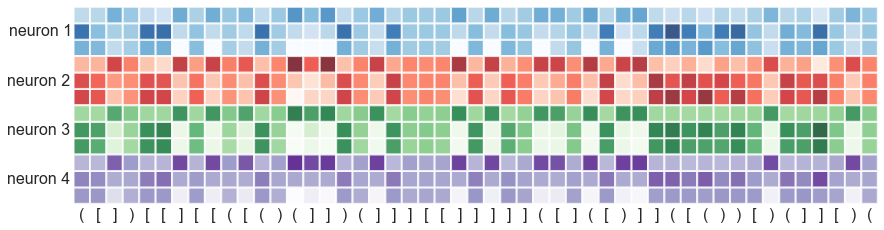

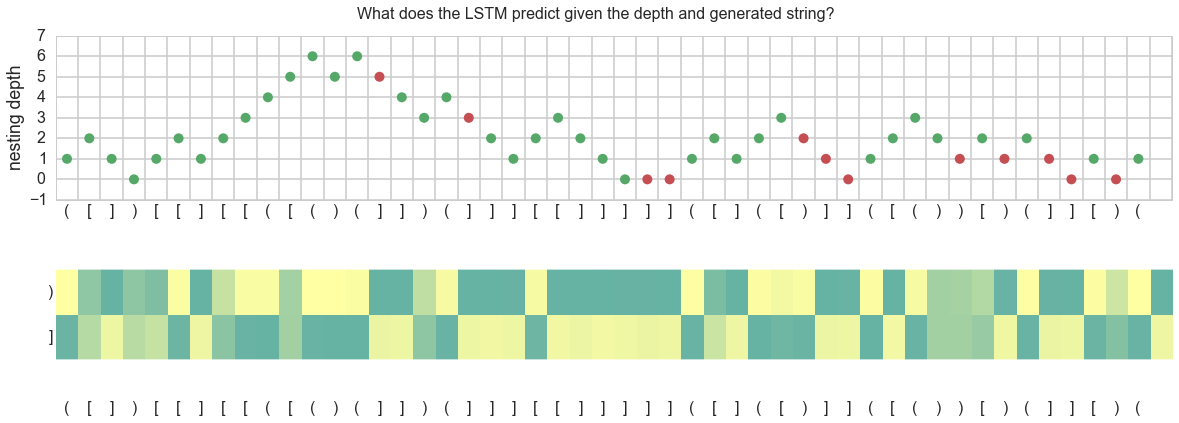

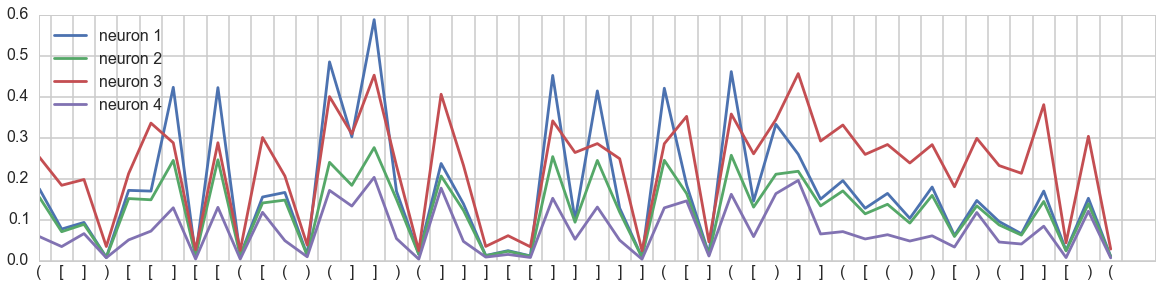

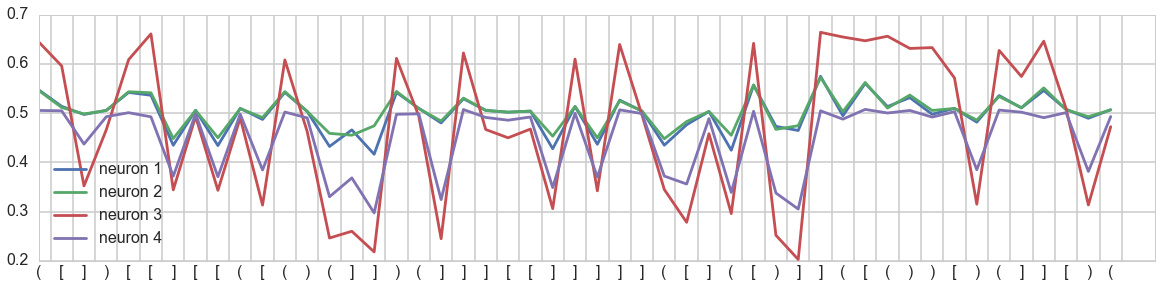

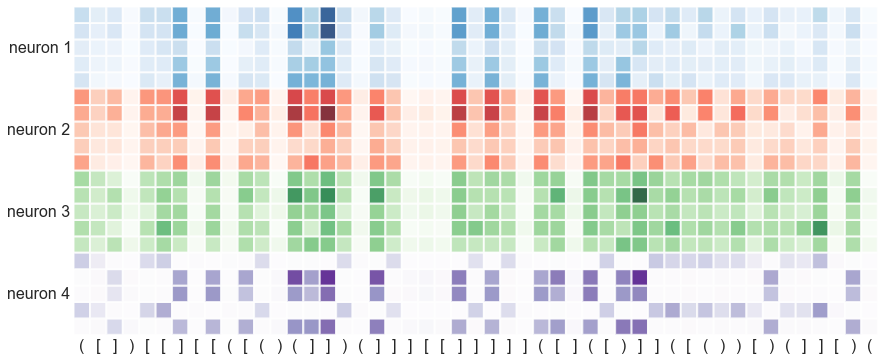

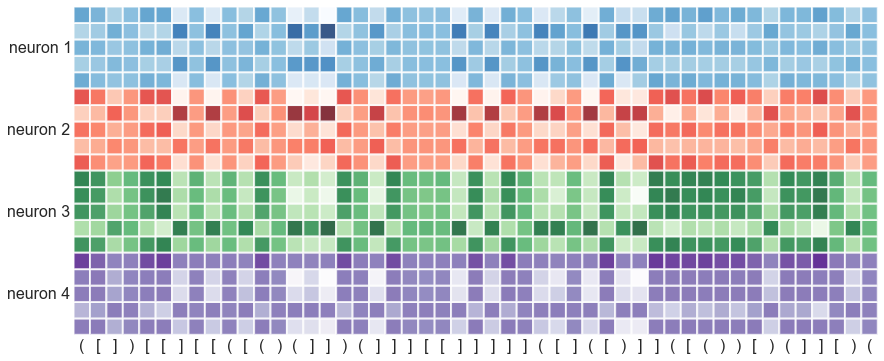

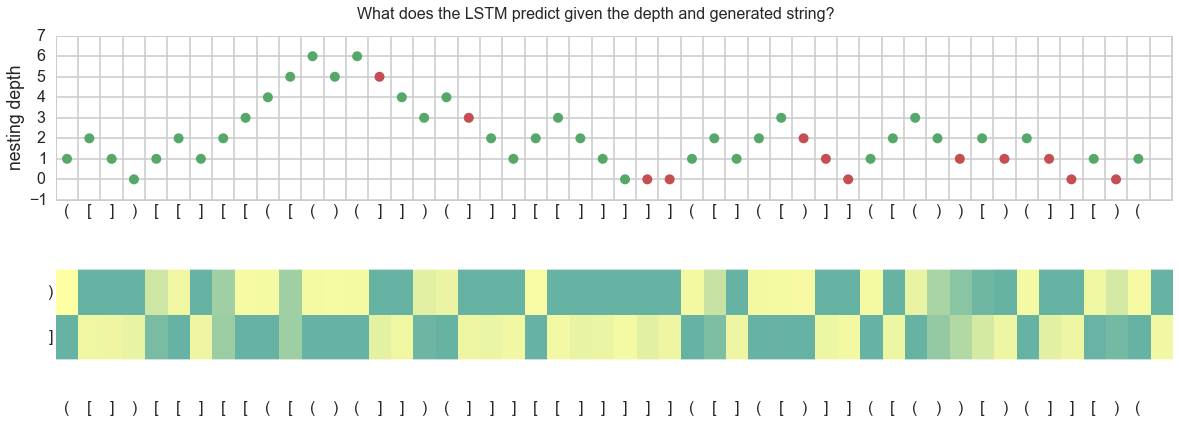

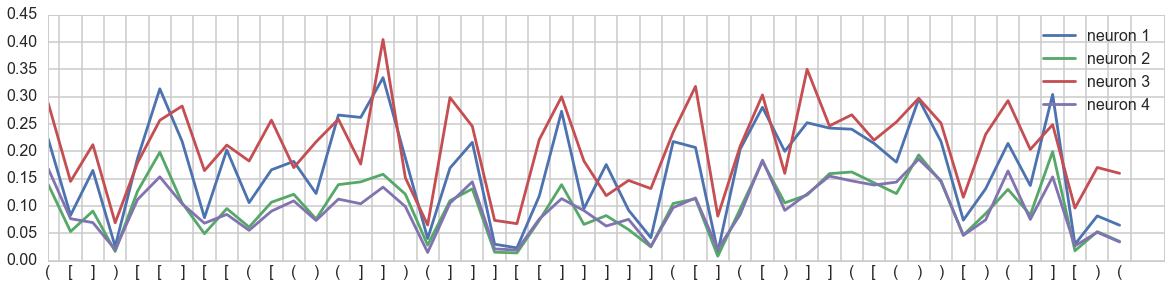

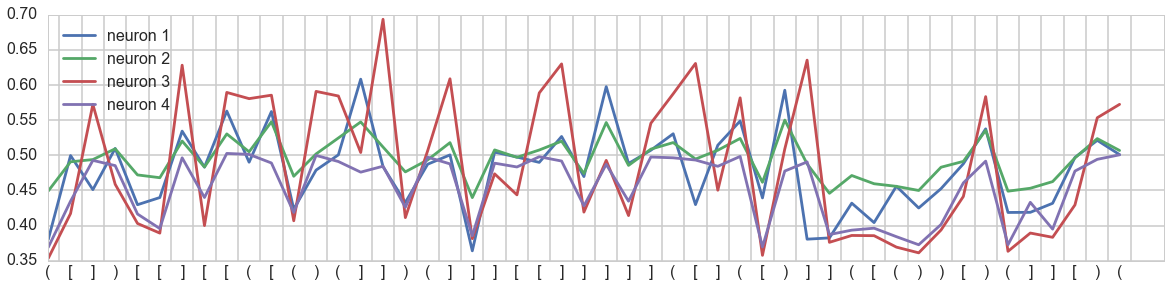

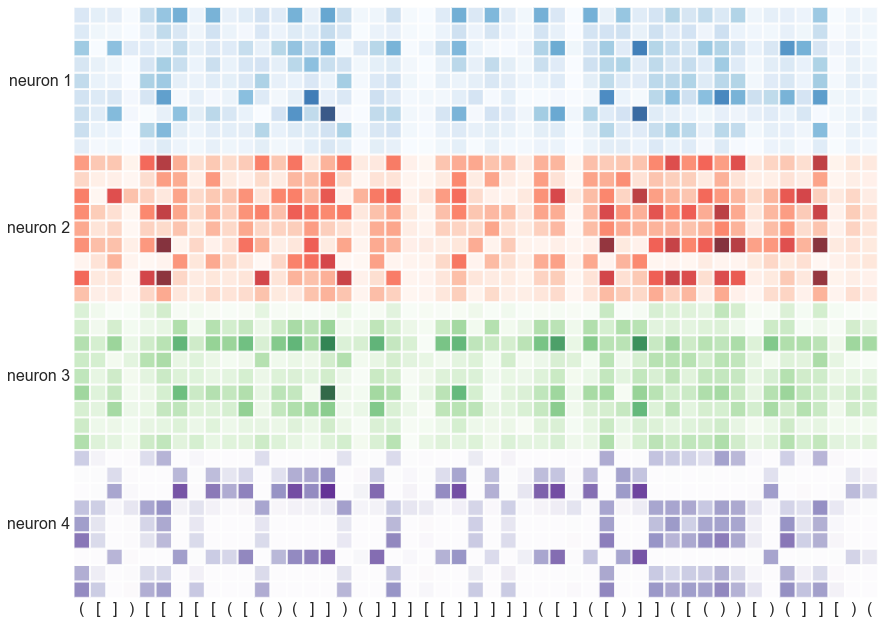

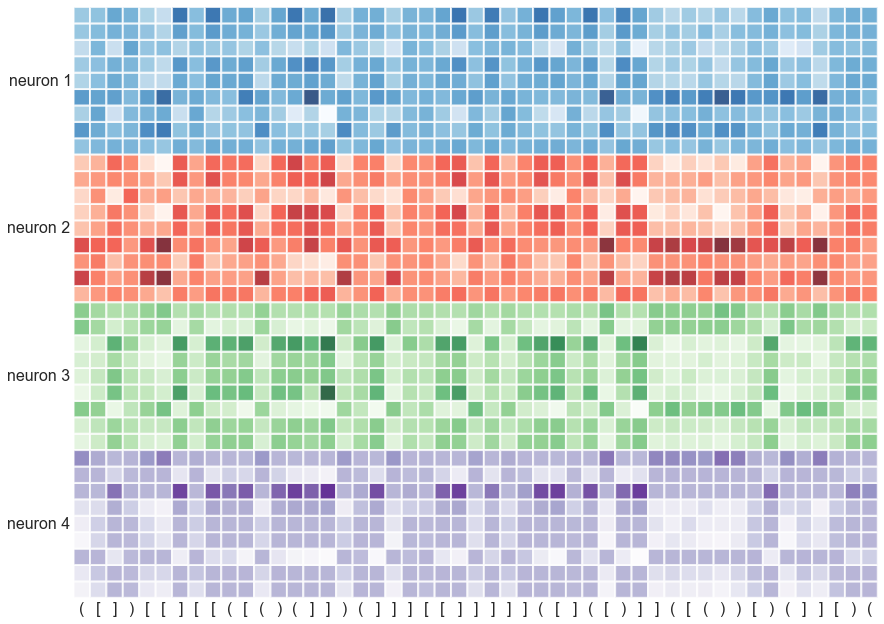

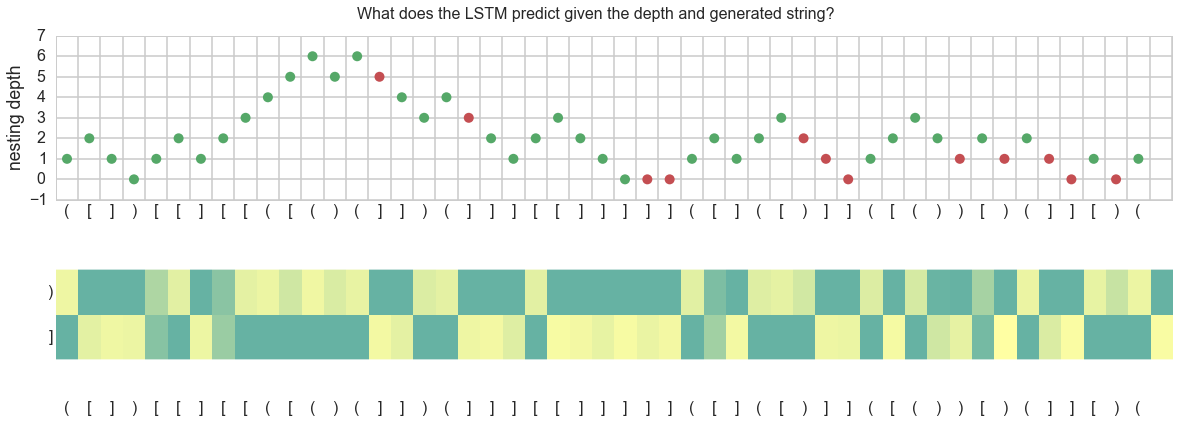

In [10]:
# specify here files to compute figures for
check_files = [f[10:] for f in os.listdir("cv") if 'cellstates' in f]
#prototyping
#check_files = ['_lm_test3_epoch41.21_1.0969.txt']

output_path = create_dir('images')
dpi = 450
ext = '.pdf'


#need to modify for > 1 sample
for j in xrange(len(check_files)):
    curr_cellstates = pd.read_csv(os.path.join('cv', 'cellstates'+check_files[j]), header=None)
    curr_probs = pd.read_csv(os.path.join('cv', 'probabilities'+check_files[j]), header=None)
    curr_probs.columns = ['1','2','3','4']
    curr_probs = curr_probs.apply(lambda x: np.exp(x))
    curr_sample = pd.read_csv(os.path.join('cv', 'sample'+check_files[j]), header=None).T
    curr_sample.columns = ['s']

    sample_text = ''.join([mapping[i] for i in list(curr_sample.s)[:-1]])

    # 4 neurons
    K = curr_cellstates.shape[1]
    N = 4
    ## plot colored language sample
    #pal5 = sns.color_palette("RdBu_r", 6)
    #parse_paren(sample_text, pal5)

    # split for the 4 neurons
    # it holds curr_cellstates.shape[0]/4 == curr_probs.shape[0]-1 (note the -1 due to first input character!)
    cellstates = {}
    for i in xrange(N):
        cellstates[i] = np.array(curr_cellstates.iloc[curr_cellstates.shape[0] / N * i:curr_cellstates.shape[0] / N * (i+1)])

    # do batch plotting and saving

    # plot excitement
    fig = plt.figure(figsize=(20,15))
    ax = plt.subplot(312)
    plt.rcParams["figure.figsize"] = [20, 4]
    plotNeuronExcitement(ax, cellstates, curr_sample, useAbs=True)
    #removeSpines(ax)
    plt.savefig(os.path.join(output_path, 'abs_excitement'+check_files[j]+ext), dpi=dpi)

    fig = plt.figure(figsize=(20,15))
    ax = plt.subplot(312)
    plt.rcParams["figure.figsize"] = [20, 4]
    plotNeuronExcitement(ax, cellstates, curr_sample, useAbs=False)
    #removeSpines(ax)
    plt.savefig(os.path.join(output_path, 'tot_excitement'+check_files[j]+ext), dpi=dpi)

    heatmapsize = (curr_cellstates.shape[0] / N, N * K)
    # plot heatmap
    fig = plt.figure(figsize=heatmapsize)
    ax = plt.subplot(312)
    plotNeuronHeatmap(ax, cellstates, curr_sample, useAbs=True)
    removeSpines(ax)
    plt.savefig(os.path.join(output_path, 'abs_cstate'+check_files[j]+ext), dpi=dpi)

    fig = plt.figure(figsize=heatmapsize)
    ax = plt.subplot(312)
    plotNeuronHeatmap(ax, cellstates, curr_sample, useAbs=False)
    removeSpines(ax)
    plt.savefig(os.path.join(output_path, 'tot_cstate'+check_files[j]+ext), dpi=dpi)
    
    # plot depth plot
    fig = plt.figure(figsize=(20,10))
    plotDepthPlot(fig, sample_text, curr_sample, curr_probs)
    plt.savefig(os.path.join(output_path, 'depth'+check_files[j]+ext), dpi=dpi)

In [11]:
'done'

'done'